# Testing

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torchvision import transforms, models
import torchvision.models as models
from PIL import Image
import os

from src.globals import TEST_DIR, DEVICE


/home/hakim/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the presaved model

In [2]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=lambda storage, loc: storage)
    model = models.resnet34()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 5)
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model


## Tie the class indices to their names

In [3]:
def find_classes(dir):
    classes = os.listdir(dir)
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


classes, c_to_idx = find_classes(TEST_DIR)
classes


['0% Rotten', '100% Rotten', '25% Rotten', '50% Rotten', '75% Rotten']

In [4]:
def process_image(image):
    # Converting image to PIL image using image file path
    pil_im = Image.open(image)
    # Building image transform
    transform = transforms.Compose([
        transforms.Resize((244, 244)),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd


In [5]:
def predict(image_path, model, topk=5):
    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).to(DEVICE)
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.inference_mode():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    #conf, predicted = torch.max(output.data, 1)
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]

    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]

    return conf, predicted


In [6]:
def plot_solution(image_path, model_path, imgdir):
    conf2, predicted1 = predict(image_path, model_path, topk=5)
    names = []
    for i in range(5):
        names += [classes[predicted1[i]]]
    image = Image.open(image_path)
    f, ax = plt.subplots(2, figsize=(6, 10))

    ax[0].imshow(image)
    ax[0].set_title(imgdir)

    y_names = np.arange(len(names))
    ax[1].barh(y_names, conf2/conf2.sum(), color='red')
    ax[1].set_yticks(y_names)
    ax[1].set_yticklabels(names)
    ax[1].invert_yaxis()


plt.show()


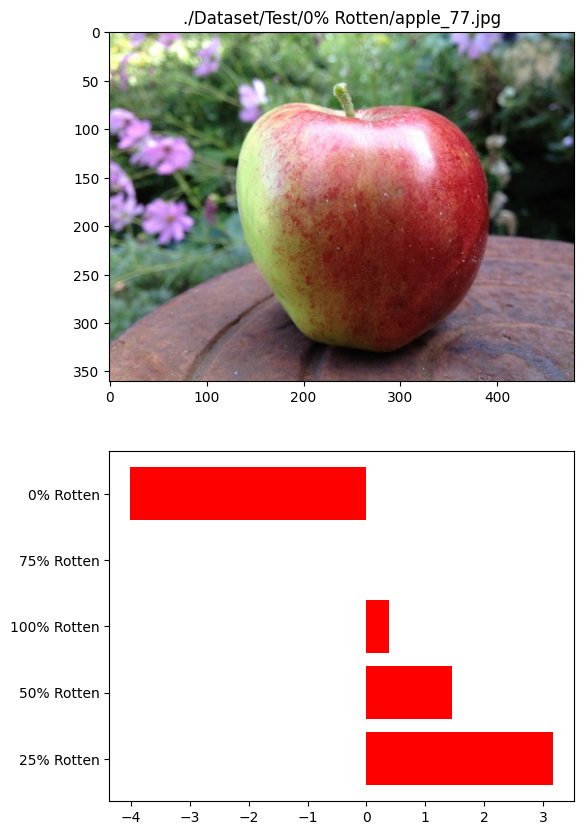

In [7]:
model_name = "modelFinal"
model_path = "../model/"+model_name+".pth"

imgdir = './Dataset/Test/0% Rotten/apple_77.jpg'
plot_solution(imgdir, model_path, imgdir)
